# 11. Arrests / Los Angeles demographics

This notebook will perform an EDA over the Department 49-00033 (Los Angeles, CA) arrests and demographics.

A hope is that this will provide some insights and experience into plotting tools, e.g. folium and holoviews, and that it may also give some insights into the data and how it should be wrangled. Hope for the best (:

# Load data

In [1]:
import folium
import folium.plugins
import geopandas
import matplotlib.pyplot
import numpy
import pandas
import seaborn
import shapely

from cpe_help import Department, util

In [2]:
dept = Department('49-00033')
dept

Department('49-00033')

## Arrests

In [3]:
!ls {dept.external_dir}

49-00033_Arrests_2015.csv  shapefiles


In [4]:
raw_arrests = pandas.read_csv(dept.external_dir / '49-00033_Arrests_2015.csv', low_memory=False)
raw_arrests.head()

,INCIDENT_DATE,INCIDENT_TIME,INCIDENT_UNIQUE_IDENTIFIER,LOCATION_DISTRICT,LOCATION_TYPE,UNKNOWN_FIELD_TYPE,SUBJECT_AGE,SUBJECT_GENDER,SUBJECT_RACE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON,UNKNOWN_FIELD_TYPE.2,CHARGE,CHARGE_DESCRIPTION,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,CROSS_STREET,LOCATION_LATITUDE,LOCATION_LONGITUDE
0,ARST DATE,TIME,RPT_ID,AREA,AREA_DESC,RD,AGE,SEX_CD,DESCENT_CD,CHRG_GRP_CD,GRP_DESC,ARST_TYP_CD,CHARGE,CHRG_DESC,LOCATION,CRSST,Location Lat,Location Lon
1,12/31/15 0:00,2345,4538991,14,Pacific,1435,43,M,H,22,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,3500 MCLAUGHLIN AV,NaN,34.0141,-118.4288
2,12/31/15 0:00,2330,4538996,1,Central,101,27,M,W,4,Aggravated Assault,F,273.5(A)PC,CORPORAL INJURY ON SPOUSE/COHABITANT/ETC,900 FIGUEROA TR,NaN,34.0663,-118.2441
3,12/31/15 0:00,2320,4539142,6,Hollywood,646,31,M,W,16,Narcotic Drug Laws,M,11350(A)HS,POSSESSION OF CONTROLLED SUBSTANCE,6300 HOLLYWOOD BL,NaN,34.1016,-118.3267
4,12/31/15 0:00,2319,4538947,21,Topanga,2189,28,M,H,22,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,VENTURA FY,WINNETKA,34.1723,-118.5709


## Block groups + precincts + census tracts

In [5]:
bgs = dept.load_block_groups()
precincts = dept.load_police_precincts()
tracts = dept.load_census_tracts()
precincts.head()

,slug,set,kind,external_i,name,display_na,url,number,phone_numb,address,...,RACE_NH_OTHER,RACE_NH_MULTIRACIAL,RACE_HISPANIC,POVERTY_TOTAL,POVERTY_BPL,POVERTY_NOT_BPL,EMPLOYMENT_TOTAL,EMPLOYMENT_EMPLOYED,EMPLOYMENT_UNEMPLOYED,geometry
0,77th-street-lapd-division,LAPD Divisions,LAPD Division,12,77th Street,77th Street LAPD Division,http://www.lapdonline.org/77th_street_communit...,12,213-485-4164,7600 S. Broadway,...,870.694270,1768.269866,103196.108821,178466.603994,54997.983164,123468.620830,81277.612528,70819.597526,10458.015002,POLYGON ((-118.3148948951553 34.00371678060566...
1,central-lapd-division,LAPD Divisions,LAPD Division,1,Central,Central LAPD Division,http://www.lapdonline.org/central_community_po...,1,213-485-3294,251 E. 6th St.,...,238.896974,1890.706219,15657.215214,54107.577791,19813.317814,34294.259978,29314.517019,26605.679738,2708.837281,POLYGON ((-118.2243816590658 34.06850962588265...
2,devonshire-lapd-division,LAPD Divisions,LAPD Division,17,Devonshire,Devonshire LAPD Division,http://www.lapdonline.org/devonshire_community...,17,818-832-0633,10250 Etiwanda Ave.,...,733.627030,6904.626033,69810.778569,223450.798257,23836.680790,199614.117467,121395.753742,112632.356647,8763.397095,POLYGON ((-118.4896378723103 34.31514263477411...
3,foothill-lapd-division,LAPD Divisions,LAPD Division,16,Foothill,Foothill LAPD Division,http://www.lapdonline.org/foothill_community_p...,16,818-756-8861,12760 Osborne St.,...,638.315695,2237.869971,124931.063478,190061.556495,36926.103431,153135.453064,96782.303394,86798.574242,9983.729152,POLYGON ((-118.3829144583267 34.29425373977321...
4,harbor-lapd-division,LAPD Divisions,LAPD Division,5,Harbor,Harbor LAPD Division,http://www.lapdonline.org/harbor_community_pol...,5,310-726-7700,2175 John S. Gibson Blvd.,...,450.633662,4938.067878,112627.182346,180304.679827,38765.744715,141538.935112,91790.858253,82673.895206,9116.963048,POLYGON ((-118.2815067203804 33.86634772230949...


# Preprocess

In [6]:
raw_arrests.shape

(126855, 18)

In [7]:
'{:.2%}'.format(
    (raw_arrests['LOCATION_LATITUDE'] == '0').mean())

'5.32%'

In [8]:
raw_arrests.head().T

,0,1,2,3,4
INCIDENT_DATE,ARST DATE,12/31/15 0:00,12/31/15 0:00,12/31/15 0:00,12/31/15 0:00
INCIDENT_TIME,TIME,2345,2330,2320,2319
INCIDENT_UNIQUE_IDENTIFIER,RPT_ID,4538991,4538996,4539142,4538947
LOCATION_DISTRICT,AREA,14,1,6,21
LOCATION_TYPE,AREA_DESC,Pacific,Central,Hollywood,Topanga
UNKNOWN_FIELD_TYPE,RD,1435,101,646,2189
SUBJECT_AGE,AGE,43,27,31,28
SUBJECT_GENDER,SEX_CD,M,M,M,M
SUBJECT_RACE,DESCENT_CD,H,W,W,H
UNKNOWN_FIELD_TYPE.1,CHRG_GRP_CD,22,4,16,22


In [9]:
variables = pandas.Series(raw_arrests.columns, index=raw_arrests.loc[0])
arrests = raw_arrests.loc[1:].copy()

# process date and drop time
arrests['INCIDENT_DATE'] = pandas.to_datetime(
    arrests['INCIDENT_DATE'], format='%m/%d/%y %H:%M')
arrests = arrests.drop('INCIDENT_TIME', axis=1)

# convert dtypes
numeric_columns = [
    'LOCATION_LATITUDE',
    'LOCATION_LONGITUDE',
]
arrests[numeric_columns] = arrests[numeric_columns].apply(pandas.to_numeric)

# drop entries where lat/lon is unknown
# (5.32% of the entries)
# (could have retrieved approximate lat/lon from address)
arrests = arrests[
    (arrests['LOCATION_LATITUDE'] != 0) &
    (arrests['LOCATION_LONGITUDE'] != 0)
]

# generate points from location
points = [shapely.geometry.Point(x, y)
          for x, y in zip(
              arrests['LOCATION_LONGITUDE'], arrests['LOCATION_LATITUDE'])]

# convert to GeoDataFrame
arrests = geopandas.GeoDataFrame(
    arrests,
    geometry=points,
    crs=util.crs.epsg4326,
)
arrests = arrests.to_crs(precincts.crs)

# Check preprocessed

Only 2015 data:

In [10]:
arrests['INCIDENT_DATE'].min()

Timestamp('2015-01-01 00:00:00')

In [11]:
arrests['INCIDENT_DATE'].max()

Timestamp('2015-12-31 00:00:00')

In [12]:
arrests.crs

{'init': 'epsg:4269'}

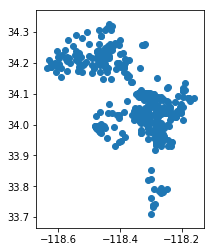

In [13]:
arrests.sample(500).plot()

# looks like LA

# EDA

## General

In [14]:
%%time

# rtree or joblib

a = arrests.sample(120, random_state=1)

union = precincts.unary_union
points = a.geometry.tolist()

[union.intersects(point) for point in points]

CPU times: user 835 ms, sys: 106 µs, total: 835 ms
Wall time: 834 ms


In [15]:
arrests_sample = arrests.sample(2000, random_state=1)
arrests_sample_big = arrests.sample(10000, random_state=1)

In [16]:
print(" Precincts CRS: {}".format(precincts.crs))
print(" Arrests CRS: {}".format(arrests.crs))
print(" Tracts CRS: {}".format(tracts.crs))
print(" BGs CRS: {}".format(bgs.crs))

 Precincts CRS: {'init': 'epsg:4269'}
 Arrests CRS: {'init': 'epsg:4269'}
 Tracts CRS: {'init': 'epsg:4269'}
 BGs CRS: {'init': 'epsg:4269'}


In [17]:
# only use intersecting regions
arrests_sample = arrests_sample[arrests_sample.intersects(precincts.unary_union)]
arrests_sample_big = arrests_sample_big[arrests_sample_big.intersects(precincts.unary_union)]
tracts = tracts[tracts.intersects(precincts.unary_union)]
bgs = bgs[bgs.intersects(precincts.unary_union)]

# set up equal-area projection
proj = util.crs.equal_area_from_geodf(tracts)
precincts = precincts.to_crs(proj)
arrests_sample = arrests_sample.to_crs(proj)
arrests_sample_big = arrests_sample_big.to_crs(proj)
tracts = tracts.to_crs(proj)
bgs = bgs.to_crs(proj)

Text(0.5, 1.0, 'Police Precincts + Block Groups')

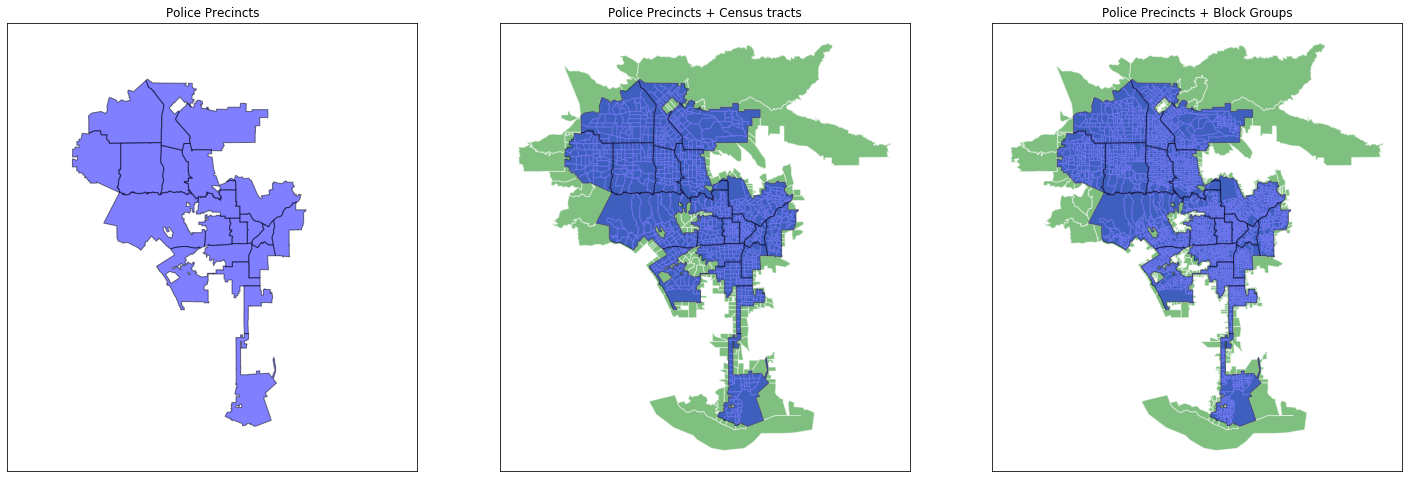

In [18]:
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(ncols=3, figsize=(25, 20))

tracts.plot(ax=ax2, color='green', edgecolor='white', alpha=0.5)
precincts.plot(ax=ax2, color='blue', edgecolor='black', alpha=0.5)

bgs.plot(ax=ax3, color='green', edgecolor='white', alpha=0.5)
precincts.plot(ax=ax3, color='blue', edgecolor='black', alpha=0.5)

bounds = ax2.axis()
ax1.axis(bounds)
precincts.plot(ax=ax1, color='blue', edgecolor='black', alpha=0.5)

for ax in (ax1, ax2, ax3):
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
ax1.set_title('Police Precincts')
ax2.set_title('Police Precincts + Census tracts')
ax3.set_title('Police Precincts + Block Groups')

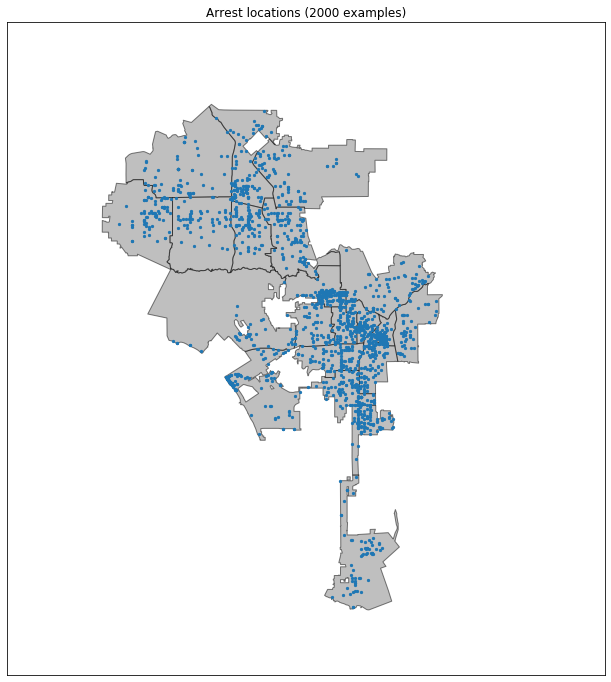

In [19]:
fig, ax = matplotlib.pyplot.subplots(figsize=(16, 12))

precincts.plot(ax=ax, color='gray', edgecolor='black', alpha=0.5)
arrests_sample.plot(ax=ax, markersize=5)

ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis(bounds)

ax.set_title('Arrest locations (2000 examples)');

## Arrests

/home/andre/miniconda3/envs/cpe/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


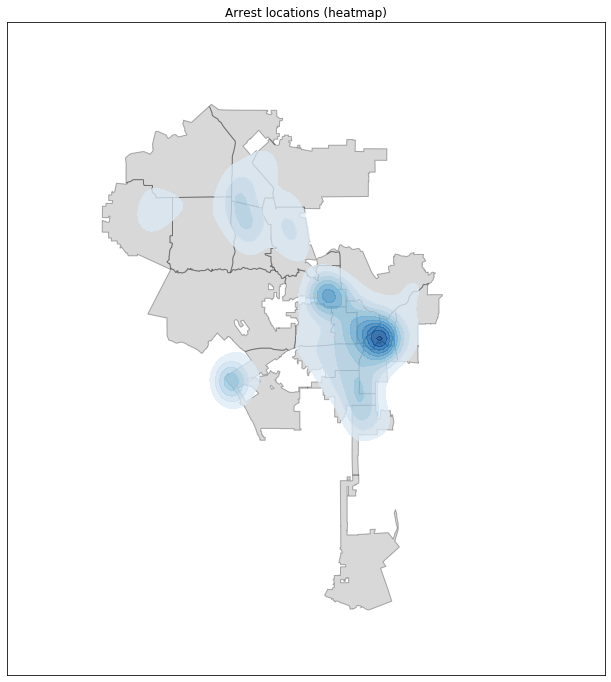

In [20]:
fig, ax = matplotlib.pyplot.subplots(figsize=(16, 12))

precincts.plot(
    ax=ax,
    color='gray',
    edgecolor='black',
    alpha=0.3,
)
seaborn.kdeplot(
    arrests_sample_big.geometry.apply(lambda point: point.x),
    arrests_sample_big.geometry.apply(lambda point: point.y),
    ax=ax,
    cmap='Blues',
    alpha=0.75,
    shade=True,
    shade_lowest=False,
)

ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis(bounds)

ax.set_title('Arrest locations (heatmap)');

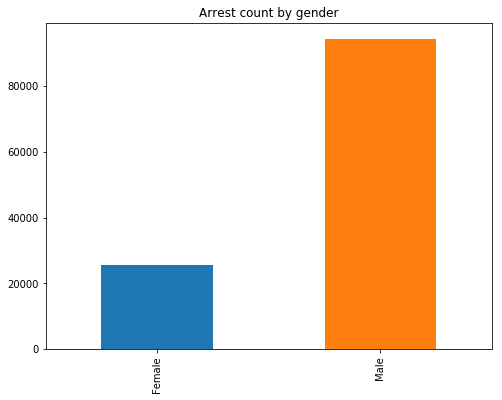

In [21]:
counts = arrests.groupby('SUBJECT_GENDER').size()
counts.index = counts.index.map(lambda x: {'M': 'Male', 'F': 'Female'}[x])
counts.index.name = None

ax = counts.plot(kind='bar', figsize=(8, 6))
ax.set_title("Arrest count by gender");

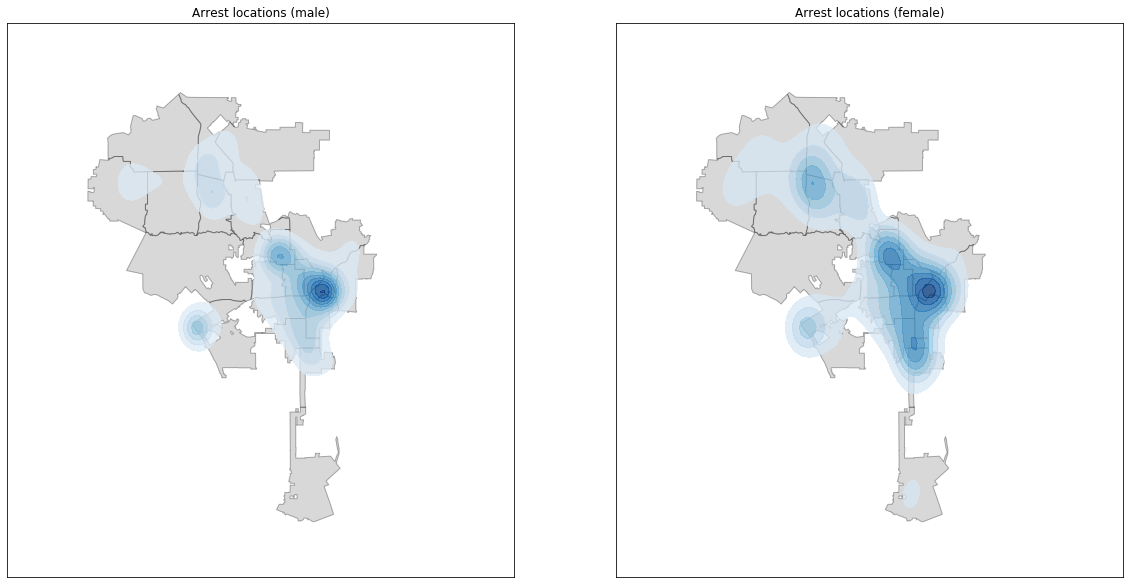

In [22]:
fig, (ax1, ax2) = matplotlib.pyplot.subplots(ncols=2, figsize=(20, 12))

for ax in (ax1, ax2):
    precincts.plot(
        ax=ax,
        color='gray',
        edgecolor='black',
        alpha=0.3,
    )
    
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis(bounds)

asb = arrests_sample_big
male = asb[asb['SUBJECT_GENDER'] == 'M']
female = asb[asb['SUBJECT_GENDER'] == 'F']

# plot 1
seaborn.kdeplot(
    male.geometry.apply(lambda point: point.x),
    male.geometry.apply(lambda point: point.y),
    ax=ax1,
    cmap='Blues',
    alpha=0.75,
    shade=True,
    shade_lowest=False,
)
ax1.set_title('Arrest locations (male)')

# plot 2
seaborn.kdeplot(
    female.geometry.apply(lambda point: point.x),
    female.geometry.apply(lambda point: point.y),
    ax=ax2,
    cmap='Blues',
    alpha=0.75,
    shade=True,
    shade_lowest=False,
)
ax2.set_title('Arrest locations (female)');

There are lots of subject races ([ref][1]). We will put all the smaller categories into Other.

[1]: https://github.com/CityOfLosAngeles/pd-geohub-migration/blob/a699ade6cc092360d9e08953d2a22bbdf77fc450/arrests.py#L137

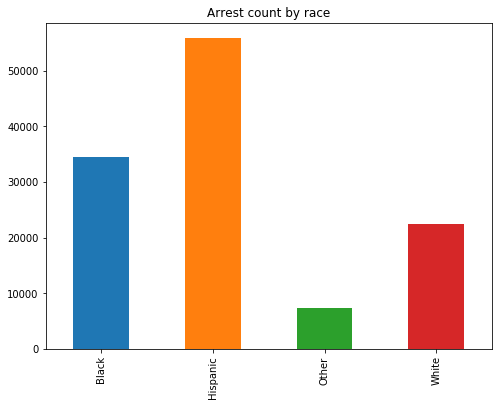

In [23]:
races = arrests['SUBJECT_RACE'].apply(
    lambda x: {'H': 'Hispanic', 'B': 'Black', 'W': 'White'}.get(x, 'Other'))
counts = arrests.groupby(races).size()
counts.index.name = None

ax = counts.plot(kind='bar', figsize=(8, 6))
ax.set_title("Arrest count by race");

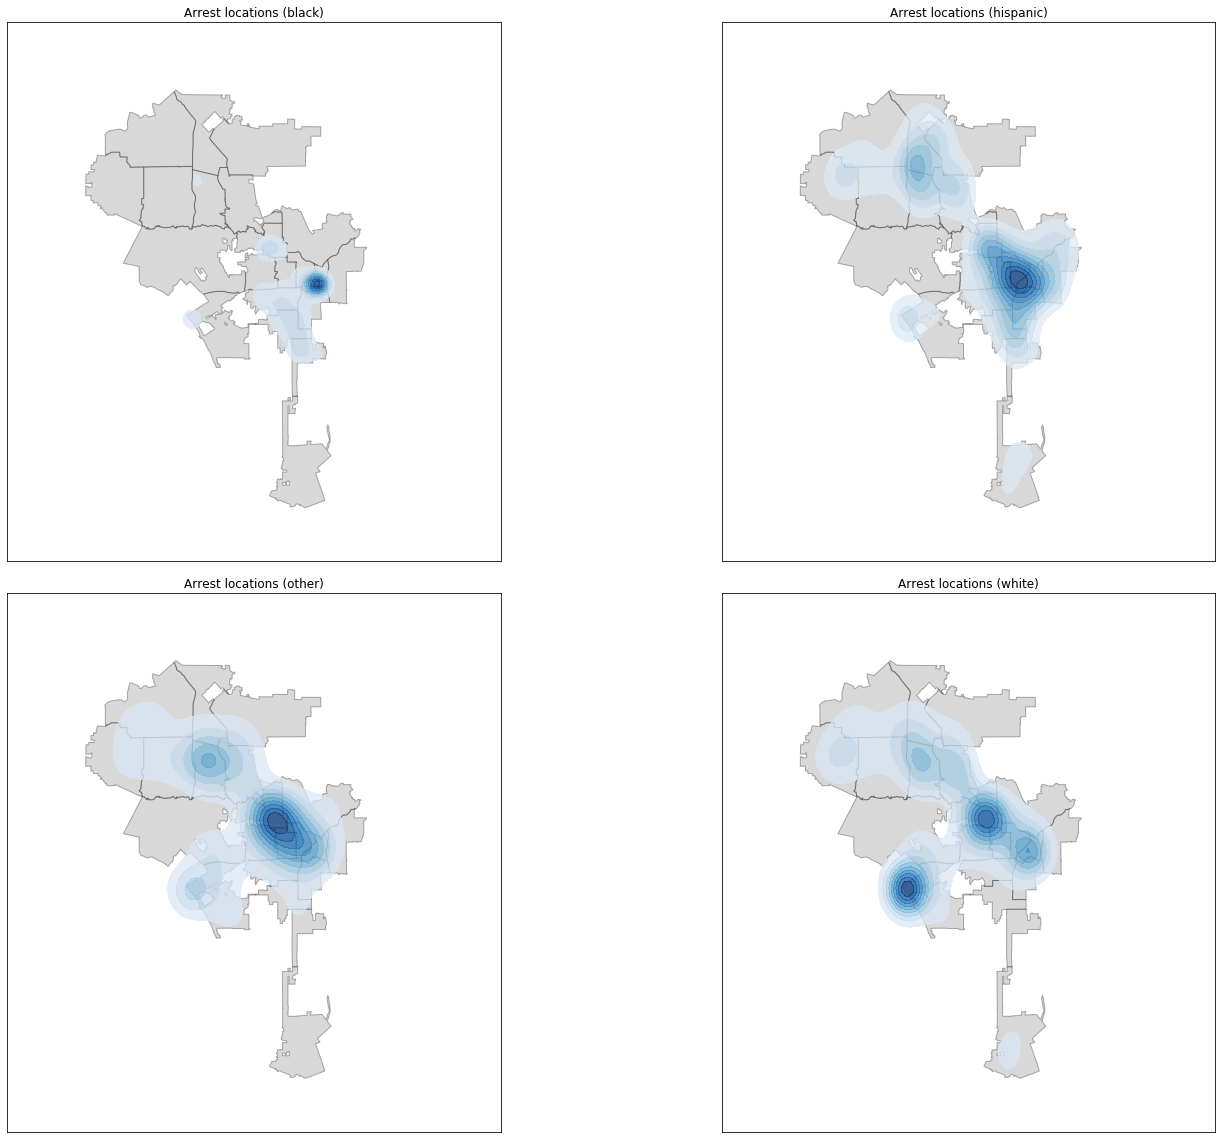

In [24]:
fig, axes = matplotlib.pyplot.subplots(nrows=2, ncols=2, figsize=(20, 16))
matplotlib.pyplot.tight_layout()

ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[1][0]
ax4 = axes[1][1]

for ax in (ax1, ax2, ax3, ax4):
    precincts.plot(
        ax=ax,
        color='gray',
        edgecolor='black',
        alpha=0.3,
    )
    
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis(bounds)

races = asb['SUBJECT_RACE'].apply(
    lambda x: {'H': 'Hispanic', 'B': 'Black', 'W': 'White'}.get(x, 'Other'))
black = asb[races == 'Black']
hispanic = asb[races == 'Hispanic']
other = asb[races == 'Other']
white = asb[races == 'White']

def _plot(df, ax, title):
    seaborn.kdeplot(
        df.geometry.apply(lambda point: point.x),
        df.geometry.apply(lambda point: point.y),
        ax=ax,
        cmap='Blues',
        alpha=0.75,
        shade=True,
        shade_lowest=False,
    )
    ax.set_title(title)
    
_plot(black, ax1, 'Arrest locations (black)')
_plot(hispanic, ax2, 'Arrest locations (hispanic)')
_plot(other, ax3, 'Arrest locations (other)')
_plot(white, ax4, 'Arrest locations (white)')

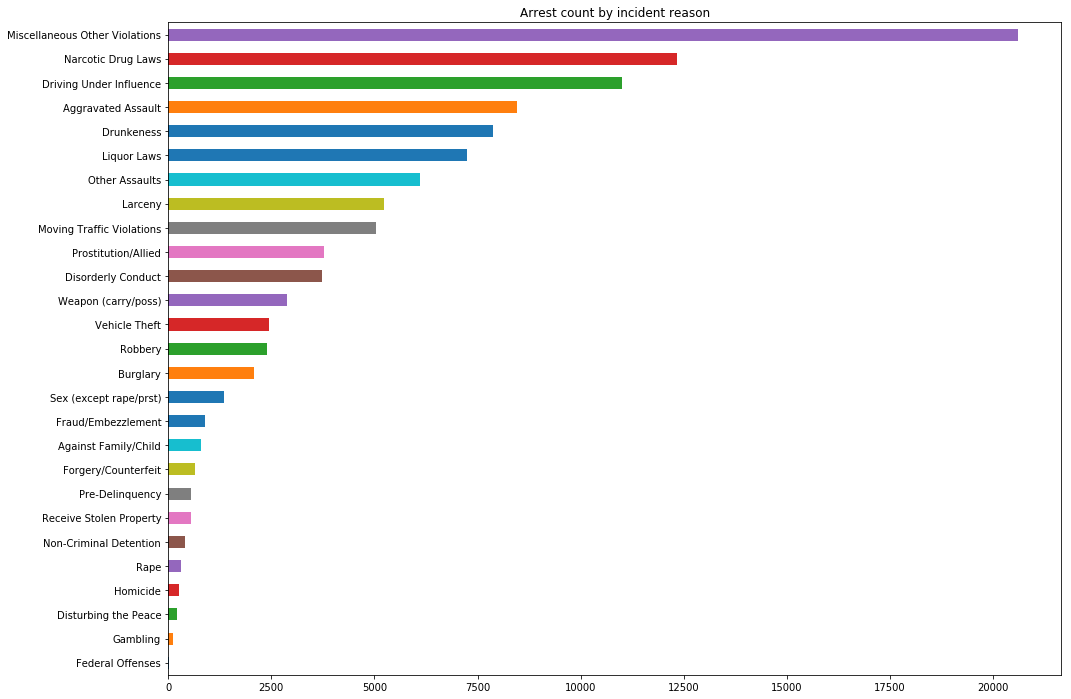

In [25]:
counts = arrests.groupby('INCIDENT_REASON').size()
counts.index.name = None
counts = counts.sort_values(ascending=True)

ax = counts.plot(kind='barh', figsize=(16, 12))
ax.set_title("Arrest count by incident reason");

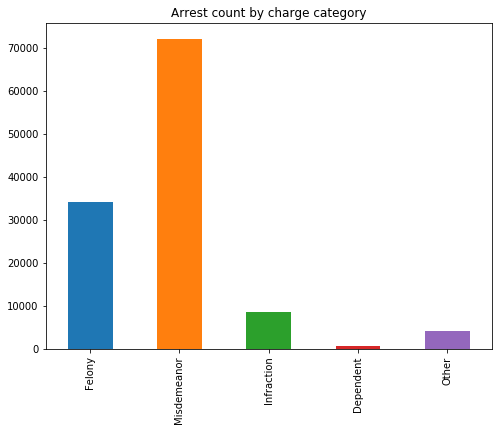

In [26]:
key = {
    'D': 'Dependent',
    'F': 'Felony',
    'I': 'Infraction',
    'M': 'Misdemeanor',
    'O': 'Other',
}

charges = arrests['UNKNOWN_FIELD_TYPE.2']
charges = charges.apply(key.get)

counts = arrests.groupby(charges).size()
counts.index.name = None
counts = counts.reindex(['Felony', 'Misdemeanor', 'Infraction', 'Dependent', 'Other'])

ax = counts.plot(kind='bar', figsize=(8, 6))
ax.set_title("Arrest count by charge category");

In [27]:
charges = arrests_sample_big['UNKNOWN_FIELD_TYPE.2'].apply(key.get)

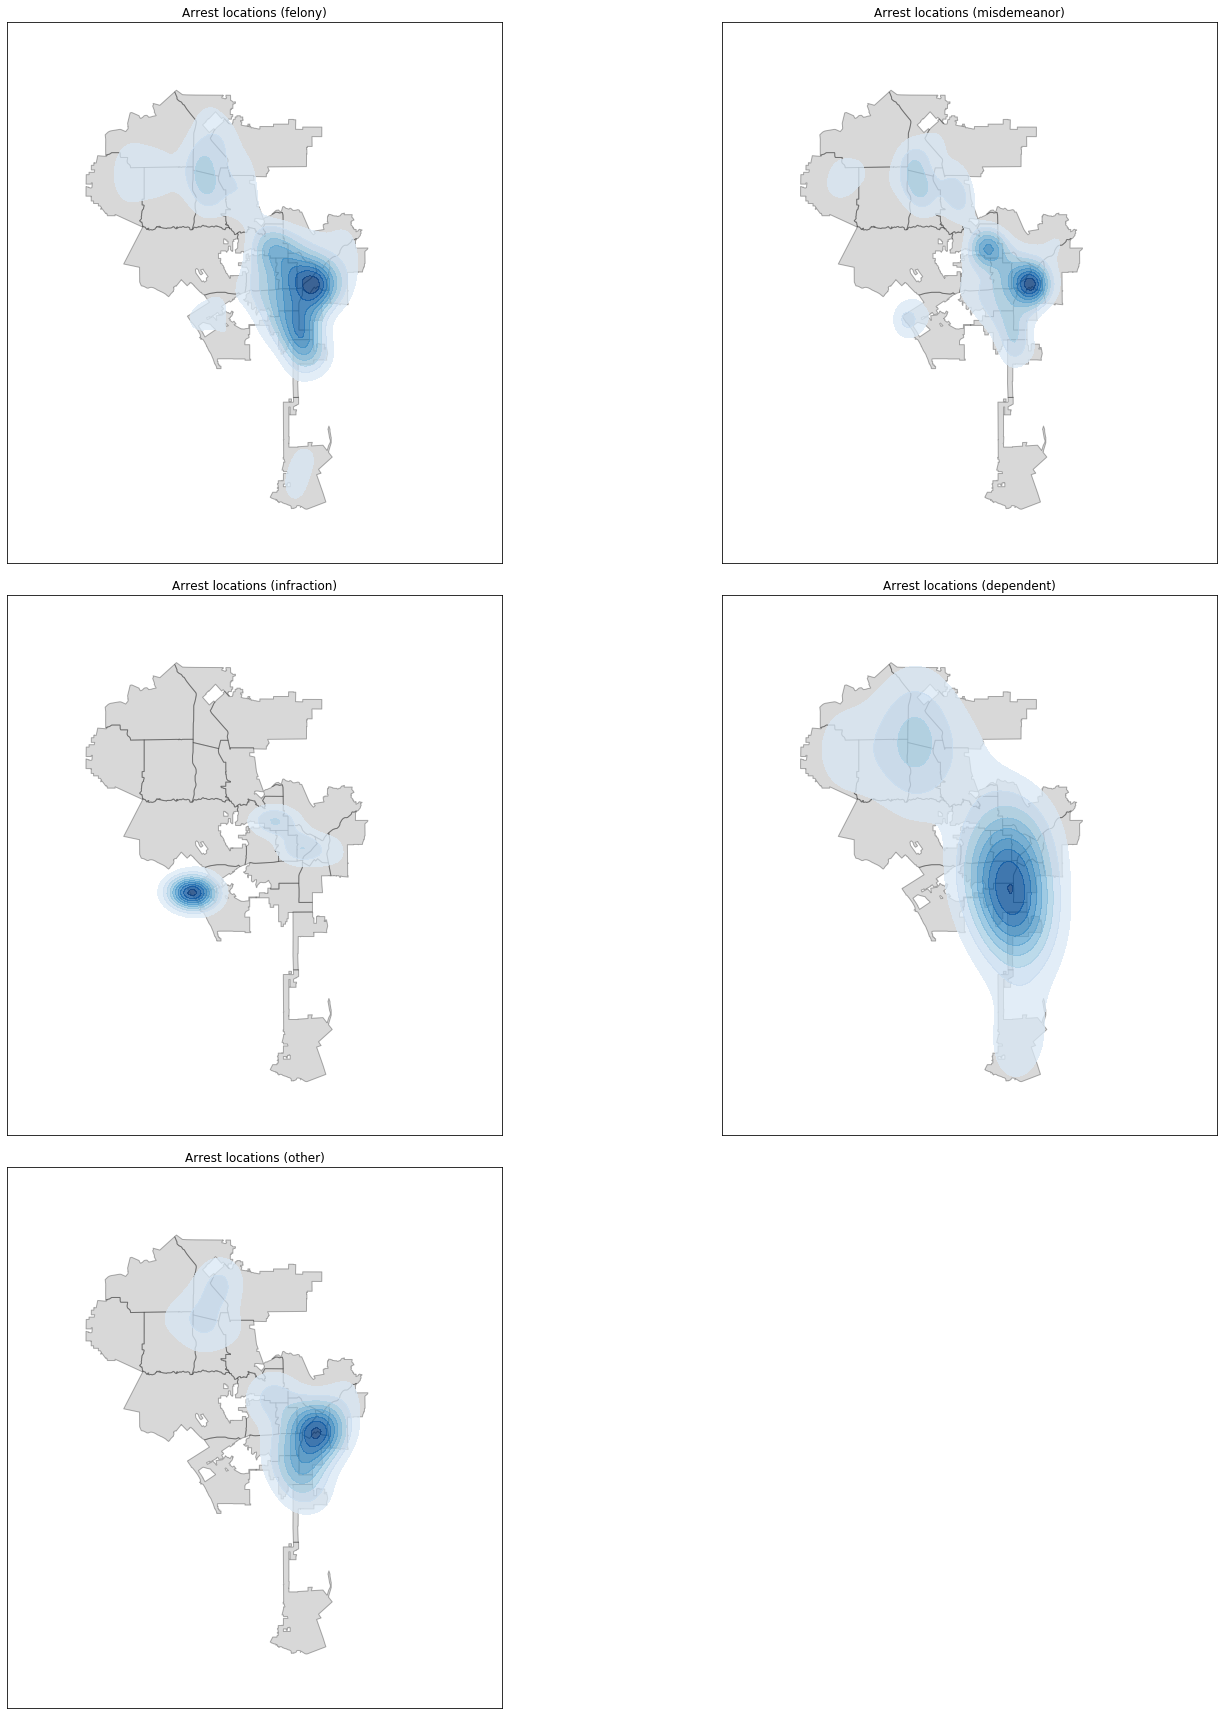

In [28]:
fig, axes = matplotlib.pyplot.subplots(nrows=3, ncols=2, figsize=(20, 24))
matplotlib.pyplot.tight_layout()

charges = arrests_sample_big['UNKNOWN_FIELD_TYPE.2'].apply(key.get)
felony = asb[charges == 'Felony']
misdemeanor = asb[charges == 'Misdemeanor']
infraction = asb[charges == 'Infraction']
other = asb[charges == 'Other']
dependent = asb[charges == 'Dependent']

ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[1][0]
ax4 = axes[1][1]
ax5 = axes[2][0]
ax6 = axes[2][1]

for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    precincts.plot(
        ax=ax,
        color='gray',
        edgecolor='black',
        alpha=0.3,
    )
    
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis(bounds)
    
ax6.set_visible(False)
    
_plot(felony, ax1, 'Arrest locations (felony)')
_plot(misdemeanor, ax2, 'Arrest locations (misdemeanor)')
_plot(infraction, ax3, 'Arrest locations (infraction)')
_plot(dependent, ax4, 'Arrest locations (dependent)')
_plot(other, ax5, 'Arrest locations (other)');